В данном ноутбуке представлены эксперименты с использованием классификатора `KNeighborsClassifier` и различными способами векторизации текста.

In [ ]:
from sklearnex import patch_sklearn
patch_sklearn()

import re
import sys
import os

import numpy as np
from tqdm import tqdm
import pandas as pd
from pymystem3 import Mystem
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from gensim.models import word2vec
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
import optuna


# Добавляем в path вышестоящую директорию для импорта  calc_metrics
sys.path.append(os.path.abspath(os.path.join("..")))

from utils import calc_metrics
from word2vec_utils import Word2VecVectorizer, Word2VecTfIdfVectorizer

RANDOM_STATE = 41825352

sns.set_style("whitegrid")
warnings.filterwarnings('ignore')

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


Загрузим данные которые были предобработаны в ноутбуке `min_baseline.ipynb`.

In [2]:
X = pd.read_csv("../data/x.csv", index_col="date")
y = pd.read_csv("../data/y.csv", index_col="date").iloc[:, 0]

Предобработаем тексты пресс-релизов.

In [51]:
# инициализируем лемматизатор
mystem = Mystem()

# загружаем стоп-слова
STOP_WORDS = set(stopwords.words("russian"))


# функция для препроцессинга текста
def preprocessor(text):

    # приводим к нижнему регистру
    text = text.lower()

    # удаляем все символы, кроме пробелов и русских букв.
    regex = re.compile("[^а-я А-ЯЁё]")
    text = regex.sub(" ", text)

    # лемматизируем тексты
    text = " ".join(mystem.lemmatize(text))

    # удаляем стоп-слова
    text = " ".join([word for word in text.split() if word not in STOP_WORDS])
    return text


Xpreproc = X.release.apply(preprocessor)

Подберем параметры для алгоритма `KNeighborsClassifier` с помощью библиотеки optuna.

In [ ]:
def objective(trial):

    # параметры для перебора
    params = {
        'C': trial.suggest_float('C', 1, 500),
        'n_neighbors': trial.suggest_int('n_neighbors', 1, 25),
        'weights': trial.suggest_categorical("weights", ['uniform', 'distance']),
        'p': trial.suggest_float('p', 1, 2),
        'max_df': trial.suggest_float('max_df', 0.1, 1),
        'min_df': trial.suggest_int('min_df', 1, 10),
    }
    
    # векторизуем текст
    vectorizer = TfidfVectorizer(max_df=params['max_df'], min_df=params['min_df'])
    tf_idf = vectorizer.fit_transform(Xpreproc).toarray()

    # определяем модель для отбора признаков
    estimator = LogisticRegression(
        penalty="l1", solver="liblinear", C=params["C"], max_iter=1000, random_state=RANDOM_STATE
    )
    
    # отбор признаков по важности
    params['max_features'] = trial.suggest_int("max_features", 5, tf_idf.shape[1])
    selector = SelectFromModel(estimator, max_features=params["max_features"])

    # определяем pipeline
    pipeline = Pipeline([
        ("selector", selector),
        (
            "model",
            KNeighborsClassifier(
                params['n_neighbors'], weights=params['weights'], p=params['p'], algorithm='brute',
            ),
        ),
    ])

    # считаем метрики на кросс валидации
    metric, _ = calc_metrics(tf_idf, y, pipeline, name=" ", plot=False, calc_jobs=-1)

    return metric


# устанавливаем уровень логирования optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

# запускаем подбор гиперпараметров
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200, show_progress_bar=True, catch=(ValueError,))

  0%|          | 0/200 [00:00<?, ?it/s]

Подобранные оптимальные параметры:

Соберем итоговый пайплайн и посчитаем метрики:

              precision    recall  f1-score   support

        -1.0       0.70      0.91      0.79        23
         0.0       0.65      0.58      0.61        26
         1.0       0.87      0.68      0.76        19

    accuracy                           0.72        68
   macro avg       0.74      0.72      0.72        68
weighted avg       0.73      0.72      0.72        68



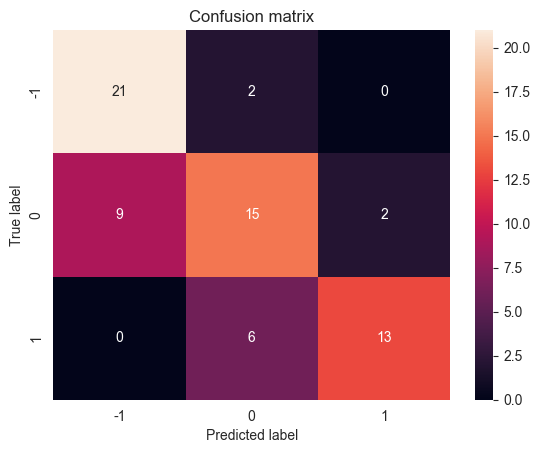

In [47]:
vectorizer = TfidfVectorizer(preprocessor=preprocessor,
                             min_df=study.best_params["min_df"],
                             max_df=study.best_params["max_df"])

tf_idf = vectorizer.fit_transform(X.release).toarray()

estimator = LogisticRegression(
    penalty="l1", solver="liblinear", C=study.best_params["C"], max_iter=1000, random_state=RANDOM_STATE
)

selector = SelectFromModel(estimator, max_features=study.best_params["max_features"])



classifier = KNeighborsClassifier(study.best_params['n_neighbors'],
                                  weights=study.best_params['weights'],
                                  p=study.best_params['p'],
                                  algorithm='brute')

pipeline = Pipeline([
    ("selector", selector),
    ("model", classifier),
])

metrics, model = calc_metrics(
    tf_idf, y,
    pipeline,
    name="K-neighbors tf_idf"
)

In [48]:
metrics

,accuracy,f1,recall,precision,roc_auc_ovr,roc_auc_ovo
K-neighbors tf_idf,0.720588,0.723135,0.724726,0.739614,0.828309,0.832314


Теперь попробуем закодировать релизы с помощью `word2vec`. Подберем размер окна:

In [67]:
best_models = {"window": [], "roc_auc": [], "model": []}

for window in tqdm(range(3, 20)):
    w2v = Word2VecVectorizer(preprocessor=preprocessor, window=window, workers=1,
                             sg=1, vector_size=50, seed=RANDOM_STATE)
    embedings_w2v = w2v.fit_transform(X.release)

    model = KNeighborsClassifier(algorithm='brute', n_neighbors=2, p=1.8, weights='distance')

    roc_auc, best_model = calc_metrics(
        embedings_w2v, y,
        model,
        name="",
        plot=False,
        n_jobs=-1,
    )

    best_models["window"].append(window)
    best_models["roc_auc"].append(roc_auc)
    best_models["model"].append(best_model)

100%|██████████| 17/17 [03:24<00:00, 12.05s/it]


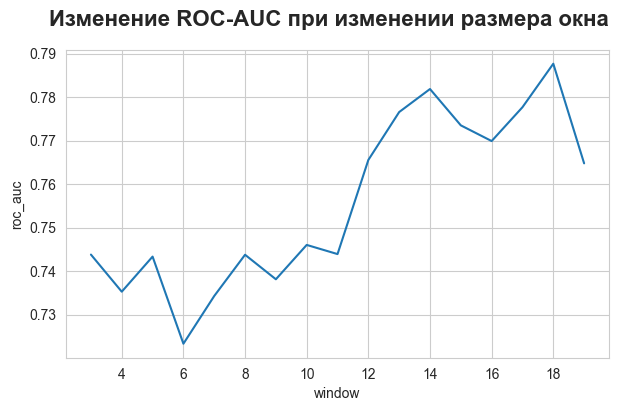

In [68]:
plt.figure(figsize=(7, 4))
data = pd.DataFrame(best_models)
sns.lineplot(x="window", y="roc_auc", data=data)
plt.suptitle("Изменение ROC-AUC при изменении размера окна", weight="bold", fontsize=16)
plt.show()

Теперь подберем параметры классификатора:

In [69]:
param_grid = ParameterGrid({
    'n_neighbors': np.arange(1, 10),
    'weights': ['uniform', 'distance'],
    'p': np.arange(1, 2, 0.05),
    'algorithm': ['brute'],
})

w2v = Word2VecVectorizer(preprocessor=preprocessor, window=18,
                         workers=1, sg=1, vector_size=50, seed=RANDOM_STATE)
embedings_w2v = w2v.fit_transform(X.release)

auc = []
for param in tqdm(param_grid):
    result = calc_metrics(embedings_w2v, y, KNeighborsClassifier, name=" ", plot=False, calc_jobs=-1, **param)
    auc.append(result)

roc_auc, best_model = max(auc, key=lambda x: x[0])

print(f"Лучшая модель - {best_model}")
print(f"ROC-AUC = {roc_auc}")

100%|██████████| 360/360 [00:26<00:00, 13.82it/s]

Лучшая модель - KNeighborsClassifier(algorithm='brute', n_neighbors=2, p=1.5500000000000005)
ROC-AUC = 0.7937202957225841


              precision    recall  f1-score   support

        -1.0       0.66      0.91      0.76        23
         0.0       0.55      0.62      0.58        26
         1.0       1.00      0.37      0.54        19

    accuracy                           0.65        68
   macro avg       0.74      0.63      0.63        68
weighted avg       0.71      0.65      0.63        68



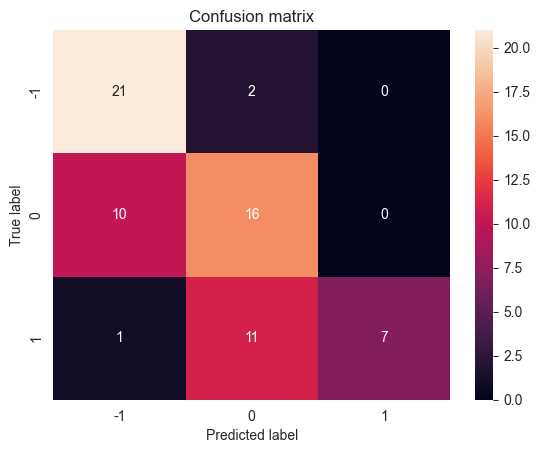

In [70]:
metric, model = calc_metrics(
    embedings_w2v,
    y,
    KNeighborsClassifier,
    name="K-neighbors word2vec",
    **best_model.get_params()
)

In [73]:
metrics = pd.concat([metrics, metric], axis=0)
metrics

,accuracy,f1,recall,precision,roc_auc_ovr,roc_auc_ovo
K-neighbors tf_idf,0.720588,0.723135,0.724726,0.739614,0.828309,0.832314
K-neighbors word2vec,0.647059,0.627972,0.632283,0.735991,0.792396,0.793720


Результат получился хуже, чем при векторизации с помощью TF-IDF. Попробуем взвешивать вектора слов с учетом их важности, а не просто усреднять:

In [14]:
best_models = {"window": [], "roc_auc": [], "model": []}

for window in tqdm(range(3, 20)):
    w2v = Word2VecTfIdfVectorizer(preprocessor=preprocessor, window=window, workers=1,
                                  sg=1, vector_size=50, seed=RANDOM_STATE)
    embedings_w2v = w2v.fit_transform(X.release)

    roc_auc, best_model = calc_metrics(
        embedings_w2v, y,
        KNeighborsClassifier,
        name="",
        plot=False,
        n_jobs=-1,
        algorithm='brute', n_neighbors=2, p=1.8, weights='distance'
    )

    best_models["window"].append(window)
    best_models["roc_auc"].append(roc_auc)
    best_models["model"].append(best_model)

100%|██████████| 17/17 [03:26<00:00, 12.13s/it]


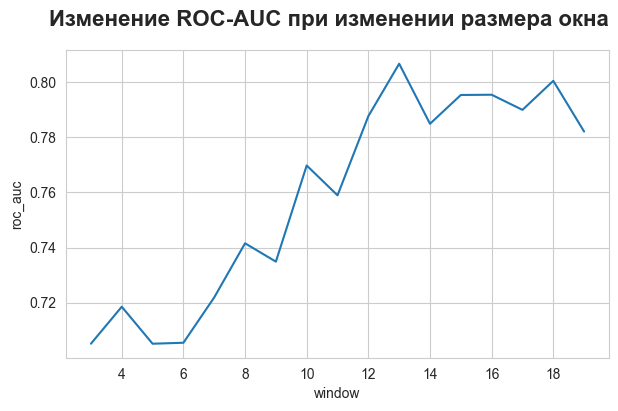

In [15]:
plt.figure(figsize=(7, 4))
data = pd.DataFrame(best_models)
sns.lineplot(x="window", y="roc_auc", data=data)
plt.suptitle("Изменение ROC-AUC при изменении размера окна", weight="bold", fontsize=16)
plt.show()

In [74]:
param_grid = ParameterGrid({
    'n_neighbors': np.arange(1, 10),
    'weights': ['uniform', 'distance'],
    'p': np.arange(1, 2, 0.05),
    'algorithm': ['brute'],
})

w2v = Word2VecTfIdfVectorizer(preprocessor=preprocessor, window=13,
                         workers=1, sg=1, vector_size=50, seed=RANDOM_STATE)
embedings_w2v = w2v.fit_transform(X.release)

auc = []
for param in tqdm(param_grid):
    result = calc_metrics(embedings_w2v, y, KNeighborsClassifier, name=" ", plot=False, calc_jobs=-1, **param)
    auc.append(result)

roc_auc, best_model = max(auc, key=lambda x: x[0])

print(f"Лучшая модель - {best_model}")
print(f"ROC-AUC = {roc_auc}")

100%|██████████| 360/360 [00:28<00:00, 12.53it/s]

Лучшая модель - KNeighborsClassifier(algorithm='brute', n_neighbors=2, p=1.7500000000000007,
                     weights='distance')
ROC-AUC = 0.8070028750806784


              precision    recall  f1-score   support

        -1.0       0.70      0.61      0.65        23
         0.0       0.56      0.73      0.63        26
         1.0       0.79      0.58      0.67        19

    accuracy                           0.65        68
   macro avg       0.68      0.64      0.65        68
weighted avg       0.67      0.65      0.65        68



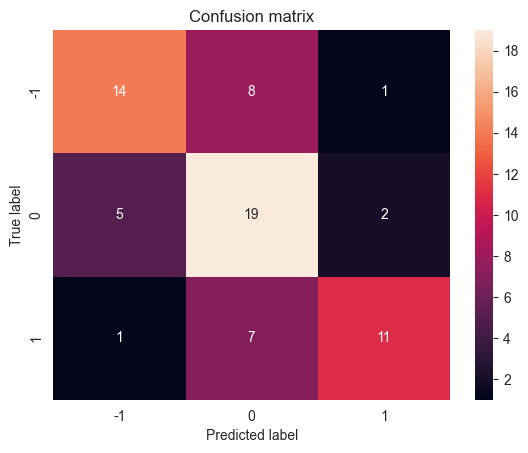

In [75]:
metric, model = calc_metrics(
    embedings_w2v,
    y,
    KNeighborsClassifier,
    name="K-neighbors weighted word2vec",
    **best_model.get_params()
)

In [76]:
metrics = pd.concat([metrics, metric], axis=0)
metrics

,accuracy,f1,recall,precision,roc_auc_ovr,roc_auc_ovo
K-neighbors tf_idf,0.720588,0.723135,0.724726,0.739614,0.828309,0.832314
K-neighbors word2vec,0.647059,0.627972,0.632283,0.735991,0.792396,0.793720
K-neighbors weighted word2vec,0.647059,0.650388,0.639471,0.681513,0.804137,0.807003


Взвешенный вариант word2vec дал более высокое качество.

In [ ]:
# metrics.to_csv('k_neighbors.csv')